# Loan Prediction Challenge

Miembros:
- Andrea Carballo Torres
- Laura Fernández Galindo
- Luis Alberto López Álvarez
- Álvaro de Rojas Maraver
- Patricia Ortuño Otero
- Pablo Rubio Noguera

# Common imports and functions

In [166]:
# General import and load data
import pandas as pd
import numpy as np
from pandas import Series, DataFrame
import warnings
from sklearn.preprocessing import LabelEncoder

# Downsampling
from sklearn.utils import resample

# Training and test spliting
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

# Estimators
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

from sklearn.naive_bayes import GaussianNB

from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier

# TPOT
from sklearn.feature_selection import SelectPercentile, f_classif
from sklearn.pipeline import make_pipeline, make_union
from sklearn.preprocessing import MinMaxScaler
from tpot.builtins import StackingEstimator
from tpot.export_utils import set_param_recursive

# Evaluation
from sklearn import metrics
from sklearn.model_selection import cross_val_score, KFold, StratifiedKFold
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score, make_scorer

# Optimization
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

# Cost sensitive learning
from imblearn.over_sampling import SMOTE

# Visualisation
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(color_codes=True)

#df = pd.read_csv('/kaggle/input/loan-approval-prediction-pennsylvania/train.csv')
df = pd.read_csv('/kaggle/input/train-antiguo/train.csv')

#df = pd.concat([df,df_old]).drop_duplicates().reset_index(drop=True)

dfnolabel = pd.read_csv('/kaggle/input/loan-approval-prediction-pennsylvania/test_nolabel.csv')

# if matplotlib is not set inline, you will not see plots
#alternatives auto gtk gtk2 inline osx qt qt5 wx tk
#%matplotlib auto
#%matplotlib qt
%matplotlib inline

/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3553: DtypeWarning: Columns (8) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


La función **print_evaluation_metrics** se utiliza para mostrar la accuracy, la matriz de confusión y un report sobre las métricas de precisión, recall y f1-score sobre los datos predichos y esperados de un sistema:

In [167]:
def print_evaluation_metrics(model, predicted, expected):
    # Compute accuracy score
    accuracy = metrics.accuracy_score(expected, predicted)
    
    # Compute confusion matrix
    conf_matrix = metrics.confusion_matrix(expected, predicted)

    # Compute classification report
    class_report = classification_report(expected, predicted)

    # Print accuracy score
    print("Accuracy Score:")
    print("{:.5%}".format(accuracy))
    print("\n")

    # Print confusion matrix
    print("Confusion Matrix:")
    print(conf_matrix)
    print("\n")

    # Print classification report
    print("Classification Report:")
    print(class_report)
    print("\n")
    
    y_pred_prob = model.predict_proba(X_test)[:,1]
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
    plt.plot(fpr, tpr)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.title('ROC curve for Loan Classification')
    plt.xlabel('False Positive Rate (1 - Recall)')
    plt.ylabel('True Positive Rate (Sensitivity)')
    plt.grid(True)
    print('AUC: ', roc_auc_score(expected, predicted))

**print_evaluation_metrics2** produce los mismos resultados, pero utiliza la función decision_function() para obtener las predicciones necesarias para la curva ROC, ya que modelos como el SGCClassifier que se emplea en el stacking no pueden utilizar la función predict_proba():

In [168]:
def print_evaluation_metrics2(model, predicted, expected):
    # Compute accuracy score
    accuracy = metrics.accuracy_score(expected, predicted)
    
    # Compute confusion matrix
    conf_matrix = metrics.confusion_matrix(expected, predicted)

    # Compute classification report
    class_report = classification_report(expected, predicted)

    # Print accuracy score
    print("Accuracy Score:")
    print("{:.5%}".format(accuracy))
    print("\n")

    # Print confusion matrix
    print("Confusion Matrix:")
    print(conf_matrix)
    print("\n")

    # Print classification report
    print("Classification Report:")
    print(class_report)
    print("\n")
    
    y_pred_prob = model.decision_function(X_test)
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
    plt.plot(fpr, tpr)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.title('ROC curve for Loan Classification')
    plt.xlabel('False Positive Rate (1 - Recall)')
    plt.ylabel('True Positive Rate (Sensitivity)')
    plt.grid(True)
    print('AUC: ', roc_auc_score(expected, predicted))

**print_evaluation_metrics_nn** es la versión de la función anterior para un red neuronal:

In [169]:
def print_evaluation_metrics_nn(model, predicted, expected):
    # Compute accuracy score
    accuracy = metrics.accuracy_score(expected, predicted)
    
    # Compute confusion matrix
    conf_matrix = metrics.confusion_matrix(expected, predicted)

    # Compute classification report
    class_report = classification_report(expected, predicted)

    # Print accuracy score
    print("Accuracy Score:")
    print("{:.5%}".format(accuracy))
    print("\n")

    # Print confusion matrix
    print("Confusion Matrix:")
    print(conf_matrix)
    print("\n")

    # Print classification report
    print("Classification Report:")
    print(class_report)
    print("\n")
    y_pred_prob = model.predict(X_test)
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
    plt.plot(fpr, tpr)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.title('ROC curve for Loan Classification')
    plt.xlabel('False Positive Rate (1 - Recall)')
    plt.ylabel('True Positive Rate (Sensitivity)')
    plt.grid(True)
    print('AUC: ', roc_auc_score(expected, predicted))

La función **build_array** se utiliza para obtener una matriz que represente los posibles valores de vecinos para encontrar los mejores hiperparámetros para kNN.

Se escogen utilizando la regla de la raíz cuadrada que se explica a continuación. La regla de la raíz cuadrada (K=sqrt(N)) se utiliza a menudo como una guía rápida para elegir un valor de K cuando no hay otra información disponible. Pero en algunos casos, puede ser necesario ajustar K para mejorar el rendimiento del modelo en el conjunto de datos específico. 

En general, se recomienda probar diferentes valores de K y seleccionar aquel que brinde el mejor rendimiento en el conjunto de datos en cuestión. Cuando se trata de un problema de dos clases, es mejor elegir un valor impar para K. De lo contrario, puede surgir un escenario en el que el número de vecinos en cada clase sea el mismo. Además, el valor de K no debe ser un múltiplo del número de clases presentes.

Esta función por tanto construye una matriz de posibles valores IMPARES y NO MÚLTIPLOS de la cantidad de clases del valor a predecir, en torno a sqrt(N), siendo N el número total de muestras juntando ambas clases (0 y 1).

In [170]:
def build_array(value_counts):
    total = value_counts.sum()
    
    # Compute the square root of the total
    sqrt_total = int(np.sqrt(total))

    # Build an array of 13 odd integers centered around the square root
    odd_array = np.arange(sqrt_total-12, sqrt_total+13, 2)
    odd_array = odd_array[odd_array > 0]
    odd_array = odd_array[odd_array <= total]
    return odd_array

# Clean data

## Visualize data

In [171]:
df.head()

,id,LoanNr_ChkDgt,Name,City,State,Bank,BankState,ApprovalDate,ApprovalFY,NoEmp,...,CreateJob,RetainedJob,FranchiseCode,UrbanRural,RevLineCr,LowDoc,DisbursementDate,DisbursementGross,BalanceGross,Accept
0,b353a0b461c,3354343008,"TOGETHER GARGOYLES, INC.",BROOKLYN,NY,JPMORGAN CHASE BANK NATL ASSOC,NY,21-Dec-88,1989,20,...,0,0,0,0,N,N,30-Apr-89,"$350,000.00",$0.00,1
1,cca24bbcc48,2349745003,LAWRENCE K. ALTHISER DBA LARRY,HARTWICK,NY,CITIZENS BANK NATL ASSOC,RI,23-Mar-07,2007,3,...,1,4,0,2,N,N,30-Apr-07,"$35,000.00",$0.00,1
2,e60644381ce,6007284009,TAAMEER CONSTRUCTION INC,BROOKLYN (BOROUGH OF NEW YORK),NY,JPMORGAN CHASE BANK NATL ASSOC,IL,9-Jan-03,2003,5,...,0,5,1,1,0,N,31-Jan-03,"$50,000.00",$0.00,1
3,ffca41a2760,6047703002,"CENTRAL CONTROL SYSTEMS, INC.",SYRACUSE,NY,MANUFACTURERS & TRADERS TR CO,NY,10-Nov-93,1994,25,...,0,0,1,0,N,N,31-Jan-94,"$190,000.00",$0.00,1
4,79e48255003,6590164004,METRO SALON,ROCHESTER,NY,MANUFACTURERS & TRADERS TR CO,NY,14-Aug-03,2003,6,...,0,0,1,1,0,Y,30-Sep-03,"$30,000.00",$0.00,1


## Study nullable and unique data

In [172]:
# Check there are not missing values
print('----------------------------- Null data -----------------------------\n')
print('Null data:\n', df.isnull().any())
print('\n')

# Check quantity of unique data
print('----------------------------- Unique values -----------------------------\n')
print('Total values: ', df['Accept'].value_counts().sum())
print('\n')
print('Quantity of unique values of [id]: ', len(df.id.unique()))
print('Quantity of unique values of [LoanNr_ChkDgt]: ', len(df.LoanNr_ChkDgt.unique()))
print('Quantity of unique values of [Name]: ', len(df.Name.unique()))
print('Quantity of unique values of [City]: ', len(df.City.unique()))
print('Quantity of unique values of [State]: ', len(df.State.unique()))
print('Quantity of unique values of [Bank]: ', len(df.Bank.unique()))
print('Quantity of unique values of [BankState]: ', len(df.BankState.unique()))
print('Quantity of unique values of [ApprovalDate]: ', len(df.ApprovalDate.unique()))
print('Quantity of unique values of [ApprovalFY]: ', len(df.ApprovalFY.unique()))
print('Quantity of unique values of [NoEmp]: ', len(df.NoEmp.unique()))
print('Quantity of unique values of [NewExist]: ', len(df.NewExist.unique()))
print('Quantity of unique values of [CreateJob]: ', len(df.CreateJob.unique()))
print('Quantity of unique values of [RetainedJob]: ', len(df.RetainedJob.unique()))
print('Quantity of unique values of [FranchiseCode]: ', len(df.FranchiseCode.unique()))
print('Quantity of unique values of [UrbanRural]: ', len(df.UrbanRural.unique()))
print('Quantity of unique values of [RevLineCr]: ', len(df.RevLineCr.unique()))
print('Quantity of unique values of [LowDoc]: ', len(df.LowDoc.unique()))
print('Quantity of unique values of [DisbursementDate]: ', len(df.DisbursementDate.unique()))
print('Quantity of unique values of [DisbursementGross]: ', len(df.DisbursementGross.unique()))
print('Quantity of unique values of [BalanceGross]: ', len(df.BalanceGross.unique()))
print('\n')

# Check quantity of missing values
print('----------------------------- Missing values -----------------------------\n')
print('Total values: ', df['Accept'].value_counts().sum())
print('\n')
print('Quantity of missing values of [id]: ', df.id.isna().sum())
print('Quantity of missing values of [LoanNr_ChkDgt]: ', df.LoanNr_ChkDgt.isna().sum())
print('Quantity of missing values of [Name]: ', df.Name.isna().sum())
print('Quantity of missing values of [City]: ', df.City.isna().sum())
print('Quantity of missing values of [State]: ', df.State.isna().sum())
print('Quantity of missing values of [Bank]: ', df.Bank.isna().sum())
print('Quantity of missing values of [BankState]: ', df.BankState.isna().sum())
print('Quantity of missing values of [ApprovalDate]: ', df.ApprovalDate.isna().sum())
print('Quantity of missing values of [ApprovalFY]: ', df.ApprovalFY.isna().sum())
print('Quantity of missing values of [NoEmp]: ', df.NoEmp.isna().sum())
print('Quantity of missing values of [NewExist]: ', df.NewExist.isna().sum())
print('Quantity of missing values of [CreateJob]: ', df.CreateJob.isna().sum())
print('Quantity of missing values of [RetainedJob]: ', df.RetainedJob.isna().sum())
print('Quantity of missing values of [FranchiseCode]: ', df.FranchiseCode.isna().sum())
print('Quantity of missing values of [UrbanRural]: ', df.UrbanRural.isna().sum())
print('Quantity of missing values of [RevLineCr]: ', df.RevLineCr.isna().sum())
print('Quantity of missing values of [LowDoc]: ', df.LowDoc.isna().sum())
print('Quantity of missing values of [DisbursementDate]: ', df.DisbursementDate.isna().sum())
print('Quantity of missing values of [DisbursementGross]: ', df.DisbursementGross.isna().sum())
print('Quantity of missing values of [BalanceGross]: ', df.BalanceGross.isna().sum())
print('\n')

# Check unique data
print('----------------------------- Unique values -----------------------------\n')
print('Possible unique values of [LowDoc]: ', df['LowDoc'].unique())
print('\n')
print('Possible unique values of [RevLineCr]: ', df['RevLineCr'].unique())
print('\n')
print('Possible unique values of [ApprovalFY]: ', df['ApprovalFY'].unique())
print('\n')
print('Possible unique values of [Bank]: ', df['Bank'].nunique())

----------------------------- Null data -----------------------------

Null data:
 id                   False
LoanNr_ChkDgt        False
Name                  True
City                 False
State                False
Bank                  True
BankState             True
ApprovalDate         False
ApprovalFY           False
NoEmp                False
NewExist              True
CreateJob            False
RetainedJob          False
FranchiseCode        False
UrbanRural           False
RevLineCr             True
LowDoc                True
DisbursementDate      True
DisbursementGross    False
BalanceGross         False
Accept               False
dtype: bool


----------------------------- Unique values -----------------------------

Total values:  40385


Quantity of unique values of [id]:  40385
Quantity of unique values of [LoanNr_ChkDgt]:  40385
Quantity of unique values of [Name]:  37616
Quantity of unique values of [City]:  2552
Quantity of unique values of [State]:  1
Quantity of uni

## Modify data based on the information each column provides

In [173]:
# Drop any columns that has as many unique values as there are total values in the dataset
columns_to_drop = [col for col in df.columns if len(df[col].unique()) == df['Accept'].value_counts().sum()]
print("Columns to be dropped: ", columns_to_drop)
df = df.drop(columns_to_drop, axis=1)

Columns to be dropped:  ['id', 'LoanNr_ChkDgt']


In [174]:
df['Name'] = df['Name'].fillna(df['Name'].value_counts().index[0])
df['Bank'] = df['Bank'].fillna(df['Bank'].value_counts().index[0])
df['BankState'] = df['BankState'].fillna(df['BankState'].value_counts().index[0])
df['NewExist'] = df['NewExist'].fillna(0)
df['RevLineCr'] = df['RevLineCr'].fillna('N')
df['LowDoc'] = df['LowDoc'].fillna('N')
df['DisbursementDate'] = df['DisbursementDate'].fillna('26-Dec-10')

df.loc[df["RevLineCr"] != "Y", "RevLineCr"] = 0
df.loc[df["RevLineCr"] == "Y", "RevLineCr"] = 1

df.loc[df["LowDoc"] != "Y", "LowDoc"] = 0
df.loc[df["LowDoc"] == "Y", "LowDoc"] = 1

df[['FirstName', 'LastName']] = df['Name'].str.split(' ', 1, expand=True)
df = df.drop('Name', axis=1)

df['LastName'] = df['LastName'].fillna("Undefined")

df['BusinessSize'] = pd.qcut(df['NoEmp'], q=3, labels=False)

df['NewBusiness'] = np.where(df['NewExist'] == 2, 1, 0)
df = df.drop('NewExist', axis=1)

df['TotalJobs'] = df['CreateJob'] + df['RetainedJob']
df = df.drop(['CreateJob', 'RetainedJob'], axis=1)

In [175]:
# Check if all null data was erased
print('----------------------------- Null data -----------------------------\n')
print('Null data:\n', df.isnull().sum())
print('\n')

----------------------------- Null data -----------------------------

Null data:
 City                 0
State                0
Bank                 0
BankState            0
ApprovalDate         0
ApprovalFY           0
NoEmp                0
FranchiseCode        0
UrbanRural           0
RevLineCr            0
LowDoc               0
DisbursementDate     0
DisbursementGross    0
BalanceGross         0
Accept               0
FirstName            0
LastName             0
BusinessSize         0
NewBusiness          0
TotalJobs            0
dtype: int64




In [176]:
# Check data types
print('----------------------------- Data types -----------------------------\n')
df.dtypes

----------------------------- Data types -----------------------------



City                 object
State                object
Bank                 object
BankState            object
ApprovalDate         object
ApprovalFY           object
NoEmp                 int64
FranchiseCode         int64
UrbanRural            int64
RevLineCr            object
LowDoc               object
DisbursementDate     object
DisbursementGross    object
BalanceGross         object
Accept                int64
FirstName            object
LastName             object
BusinessSize          int64
NewBusiness           int64
TotalJobs             int64
dtype: object

In [177]:
df['ApprovalFY']=df['ApprovalFY'].astype(str).str.extract('(\d+)').astype(int)

df['ApprovalDate'] = pd.to_datetime(df.ApprovalDate)
df['DisbursementDate'] = pd.to_datetime(df.DisbursementDate)

df['DaysToDisburse'] = (df['DisbursementDate'] - df['ApprovalDate']).dt.days

df['DaysToDisburse'] = df['DaysToDisburse'].apply(lambda x: 0 if x < 0 else x)

df['DaysToDisburseRange'] = pd.qcut(df['DaysToDisburse'], q=4, labels=False)
df = df.drop('DaysToDisburse', axis=1)

# Check if it was approved or disbursed during the great recession
df['DuringRecession'] = np.where((df['ApprovalDate'].dt.year == 2008) | 
                                 (df['DisbursementDate'].dt.year == 2008),
                                 1, 0)

# If it has a Franchise Code, then it will take a value of 1. If it didn't, a value of 0.
df.loc[(df['FranchiseCode'] != 0) & (df['FranchiseCode'] != 1), 'FranchiseCode'] = 2
df['FranchiseCode'] = df['FranchiseCode'].astype(np.int64)

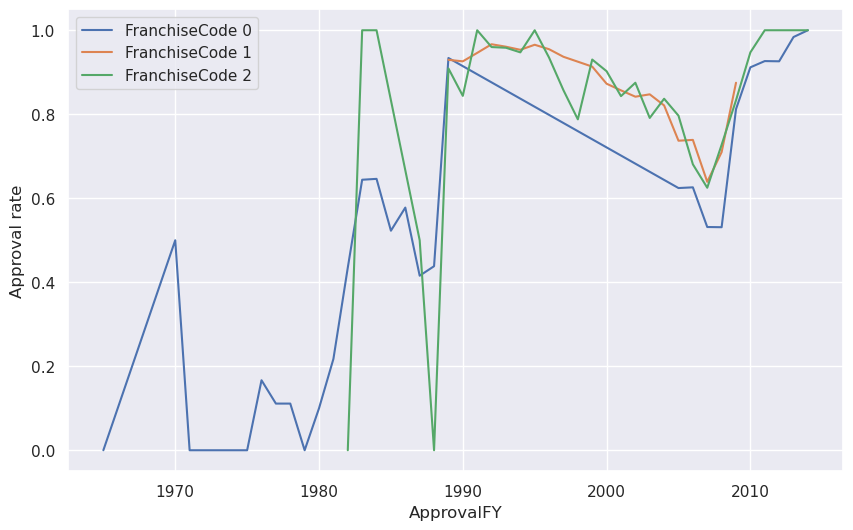

In [178]:
# Calculate approval rate for each FranchiseCode and ApprovalFY combination
df_approval_rate = df.groupby(['FranchiseCode', 'ApprovalFY']).agg({'Accept': 'mean'}).reset_index()

# Plot approval rate by FranchiseCode and ApprovalFY
fig, ax = plt.subplots(figsize=(10, 6))
for franchise_code in df_approval_rate['FranchiseCode'].unique():
    df_franchise = df_approval_rate[df_approval_rate['FranchiseCode'] == franchise_code]
    ax.plot(df_franchise['ApprovalFY'], df_franchise['Accept'], label=f'FranchiseCode {franchise_code}')
ax.set_xlabel('ApprovalFY')
ax.set_ylabel('Approval rate')
ax.legend()
plt.show()

In [179]:
# DisbursementGross: we associate a new numeric value according to the range in which the data is located.
def convertir_a_int(x):
    return int(float(x.replace('$', '').replace(' ', '').replace(',', '')))

df['DisbursementGross'] = df['DisbursementGross'].apply(convertir_a_int)
df['DisbursementRange'] = pd.qcut(df['DisbursementGross'], q=5, labels=False)

df['NoEmp_DisbursementGross'] = np.log(df['NoEmp'] * df['DisbursementGross'])
df['NoEmp_DisbursementGross_Range'] = pd.qcut(df['NoEmp_DisbursementGross'], q=4, labels=False)
df = df.drop('NoEmp_DisbursementGross', axis=1)

df['UrbanRural_NoEmp'] = df['UrbanRural'].astype(int) * np.log(df['NoEmp'])
df['UrbanRural_NoEmp'] = df['UrbanRural_NoEmp'].fillna(-999).replace([np.inf, -np.inf], -999)
df['UrbanRural_NoEmp_Range'] = pd.qcut(df['UrbanRural_NoEmp'], q=4, labels=False).astype(int)
df = df.drop('UrbanRural_NoEmp', axis=1)

/opt/conda/lib/python3.7/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [180]:
le = LabelEncoder()

df['BankState'] = le.fit_transform(df['BankState'])
df['Bank'] = le.fit_transform(df['Bank'])
df['City'] = le.fit_transform(df['City'])
df['FirstName'] = le.fit_transform(df['FirstName'])
df['LastName'] = le.fit_transform(df['LastName'])

In [181]:
# Erase unnecessary columns (APPROVALDATE, DISBURSEMENTGROSS DISBURSEMENTGROSSINT DISBURSEMENTDATE ETC.)
df = df.drop(['ApprovalDate', 'DisbursementDate', 'DisbursementGross', 'State', 'BalanceGross', 'NoEmp'], axis=1)

In [182]:
df['LowDoc'] = df['LowDoc'].astype(int, errors = 'raise')
df['Bank'] = df['Bank'].astype(int, errors = 'raise')
df['FirstName'] = df['FirstName'].astype(int, errors = 'raise')
df['LastName'] = df['LastName'].astype(int, errors = 'raise')
df['RevLineCr'] = df['RevLineCr'].astype(int, errors = 'raise')
df['ApprovalFY'] = df['ApprovalFY'].astype(int, errors = 'raise')
df['NewBusiness'] = df['NewBusiness'].astype(int, errors = 'raise')
df['BankState'] = df['BankState'].astype(int, errors = 'raise')
df['City'] = df['City'].astype(int, errors = 'raise')

In [183]:
df.dtypes

City                             int64
Bank                             int64
BankState                        int64
ApprovalFY                       int64
FranchiseCode                    int64
UrbanRural                       int64
RevLineCr                        int64
LowDoc                           int64
Accept                           int64
FirstName                        int64
LastName                         int64
BusinessSize                     int64
NewBusiness                      int64
TotalJobs                        int64
DaysToDisburseRange              int64
DuringRecession                  int64
DisbursementRange                int64
NoEmp_DisbursementGross_Range    int64
UrbanRural_NoEmp_Range           int64
dtype: object

In [184]:
df.head()

,City,Bank,BankState,ApprovalFY,FranchiseCode,UrbanRural,RevLineCr,LowDoc,Accept,FirstName,LastName,BusinessSize,NewBusiness,TotalJobs,DaysToDisburseRange,DuringRecession,DisbursementRange,NoEmp_DisbursementGross_Range,UrbanRural_NoEmp_Range
0,232,158,22,1989,0,0,0,0,1,18073,11994,2,0,0,2,0,4,3,0
1,955,78,27,2007,0,2,0,0,1,10639,15511,1,0,5,1,0,1,1,3
2,235,158,8,2003,1,1,0,0,1,17655,6675,1,0,5,0,0,1,1,2
3,2183,176,22,1994,1,0,0,0,1,3474,6786,2,0,0,2,0,3,3,0
4,1905,176,22,2003,1,1,0,1,1,11961,23689,1,0,0,1,0,0,1,3


In [185]:
dfnolabel['Name'] = dfnolabel['Name'].fillna(dfnolabel['Name'].value_counts().index[0])
dfnolabel['Bank'] = dfnolabel['Bank'].fillna(dfnolabel['Bank'].value_counts().index[0])
dfnolabel['BankState'] = dfnolabel['BankState'].fillna(dfnolabel['BankState'].value_counts().index[0])
dfnolabel['NewExist'] = dfnolabel['NewExist'].fillna(0)
dfnolabel['RevLineCr'] = dfnolabel['RevLineCr'].fillna('N')
dfnolabel['LowDoc'] = dfnolabel['LowDoc'].fillna('N')
dfnolabel['DisbursementDate'] = dfnolabel['DisbursementDate'].fillna('26-Dec-10')

dfnolabel.loc[dfnolabel["RevLineCr"] != "Y", "RevLineCr"] = 0
dfnolabel.loc[dfnolabel["RevLineCr"] == "Y", "RevLineCr"] = 1

dfnolabel.loc[dfnolabel["LowDoc"] != "Y", "LowDoc"] = 0
dfnolabel.loc[dfnolabel["LowDoc"] == "Y", "LowDoc"] = 1

dfnolabel[['FirstName', 'LastName']] = dfnolabel['Name'].str.split(' ', 1, expand=True)
dfnolabel = dfnolabel.drop('Name', axis=1)

dfnolabel['LastName'] = dfnolabel['LastName'].fillna("Undefined")

dfnolabel['BusinessSize'] = pd.qcut(dfnolabel['NoEmp'], q=3, labels=False)

dfnolabel['NewBusiness'] = np.where(dfnolabel['NewExist'] == 2, 1, 0)
dfnolabel = dfnolabel.drop('NewExist', axis=1)

dfnolabel['TotalJobs'] = dfnolabel['CreateJob'] + dfnolabel['RetainedJob']
dfnolabel = dfnolabel.drop(['CreateJob', 'RetainedJob'], axis=1)

dfnolabel['ApprovalFY']=dfnolabel['ApprovalFY'].astype(str).str.extract('(\d+)').astype(int)

dfnolabel['ApprovalDate'] = pd.to_datetime(dfnolabel.ApprovalDate)
dfnolabel['DisbursementDate'] = pd.to_datetime(dfnolabel.DisbursementDate)

dfnolabel['DaysToDisburse'] = (dfnolabel['DisbursementDate'] - dfnolabel['ApprovalDate']).dt.days

dfnolabel['DaysToDisburse'] = dfnolabel['DaysToDisburse'].apply(lambda x: 0 if x < 0 else x)

dfnolabel['DaysToDisburseRange'] = pd.qcut(dfnolabel['DaysToDisburse'], q=4, labels=False)
dfnolabel = dfnolabel.drop('DaysToDisburse', axis=1)

dfnolabel['DuringRecession'] = np.where((dfnolabel['ApprovalDate'].dt.year == 2008) | 
                                         (dfnolabel['DisbursementDate'].dt.year == 2008),
                                         1, 0)

dfnolabel.loc[(dfnolabel['FranchiseCode'] != 0) & (dfnolabel['FranchiseCode'] != 1), 'FranchiseCode'] = 2
dfnolabel['FranchiseCode'] = dfnolabel['FranchiseCode'].astype(np.int64)

#DisbursementGross: we associate a new numeric value according to the range in which the data is located.
def convertir_a_int(x):
    return int(float(x.replace('$', '').replace(' ', '').replace(',', '')))

dfnolabel['DisbursementGross'] = dfnolabel['DisbursementGross'].apply(convertir_a_int)
dfnolabel['DisbursementRange'] = pd.qcut(dfnolabel['DisbursementGross'], q=5, labels=False)

dfnolabel['NoEmp_DisbursementGross'] = np.log(dfnolabel['NoEmp'] * dfnolabel['DisbursementGross'])
dfnolabel['NoEmp_DisbursementGross_Range'] = pd.qcut(dfnolabel['NoEmp_DisbursementGross'], q=4, labels=False)
dfnolabel = dfnolabel.drop('NoEmp_DisbursementGross', axis=1)

dfnolabel['UrbanRural_NoEmp'] = dfnolabel['UrbanRural'].astype(int) * np.log(dfnolabel['NoEmp'])
dfnolabel['UrbanRural_NoEmp'] = dfnolabel['UrbanRural_NoEmp'].fillna(-999).replace([np.inf, -np.inf], -999)
dfnolabel['UrbanRural_NoEmp_Range'] = pd.qcut(dfnolabel['UrbanRural_NoEmp'], q=4, labels=False).astype(int)
dfnolabel = dfnolabel.drop('UrbanRural_NoEmp', axis=1)

le = LabelEncoder()

dfnolabel['BankState'] = le.fit_transform(dfnolabel['BankState'])
dfnolabel['Bank'] = le.fit_transform(dfnolabel['Bank'])
dfnolabel['City'] = le.fit_transform(dfnolabel['City'])
dfnolabel['FirstName'] = le.fit_transform(dfnolabel['FirstName'])
dfnolabel['LastName'] = le.fit_transform(dfnolabel['LastName'])
    
# Convertimos los tipos a enteros
# Eliminamos campos auxiliares (APPROVALDATE, DISBURSEMENTGROSS DISBURSEMENTGROSSINT DISBURSEMENTDATE ETC.)
dfnolabel = dfnolabel.drop(['LoanNr_ChkDgt', 'ApprovalDate', 'DisbursementDate', 'DisbursementGross', 'State', 'BalanceGross', 'NoEmp'], axis=1)

dfnolabel['LowDoc'] = dfnolabel['LowDoc'].astype(int, errors = 'raise')
dfnolabel['Bank'] = dfnolabel['Bank'].astype(int, errors = 'raise')
dfnolabel['City'] = dfnolabel['City'].astype(int, errors = 'raise')
dfnolabel['RevLineCr'] = dfnolabel['RevLineCr'].astype(int, errors = 'raise')
dfnolabel['ApprovalFY'] = dfnolabel['ApprovalFY'].astype(int, errors = 'raise')
dfnolabel['NewBusiness'] = dfnolabel['NewBusiness'].astype(int, errors = 'raise')
dfnolabel['BankState'] = dfnolabel['BankState'].astype(int, errors = 'raise')
dfnolabel['FirstName'] = dfnolabel['FirstName'].astype(int, errors = 'raise')
dfnolabel['LastName'] = dfnolabel['LastName'].astype(int, errors = 'raise')

/opt/conda/lib/python3.7/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [186]:
dfnolabel.head()

,id,City,Bank,BankState,ApprovalFY,FranchiseCode,UrbanRural,RevLineCr,LowDoc,FirstName,LastName,BusinessSize,NewBusiness,TotalJobs,DaysToDisburseRange,DuringRecession,DisbursementRange,NoEmp_DisbursementGross_Range,UrbanRural_NoEmp_Range
0,82e99051e9c,349,76,14,1995,1,0,0,1,375,153,1,0,0,2,0,2,2,0
1,df1cfad8fb6,173,124,15,2009,0,1,0,0,1916,2460,0,0,0,1,1,1,0,0
2,2d3d3198980,664,96,3,2004,1,1,1,0,1471,1503,0,1,4,2,0,0,0,1
3,3f56f41d280,656,17,23,2004,1,2,0,0,24,919,2,0,26,1,0,2,3,3
4,cca77d2e8a4,101,76,14,2007,0,1,0,0,1591,1353,1,1,4,0,0,2,2,2


## Look at the correlation between each column with Accept

In [187]:
# Check how many values there are for each class of the Acept column
print('----------------------------- Accept -----------------------------\n')
print('Accept values: \n', df['Accept'].value_counts())

----------------------------- Accept -----------------------------

Accept values: 
 1    32161
0     8224
Name: Accept, dtype: int64


Accept                           1.000000
FranchiseCode                    0.234700
DaysToDisburseRange              0.211857
ApprovalFY                       0.201101
UrbanRural                       0.163045
UrbanRural_NoEmp_Range           0.116399
NoEmp_DisbursementGross_Range    0.108862
RevLineCr                        0.108421
Bank                             0.100534
DisbursementRange                0.096345
LowDoc                           0.091241
DuringRecession                  0.075311
BusinessSize                     0.074071
BankState                        0.040215
City                             0.034819
NewBusiness                      0.027081
FirstName                        0.007952
TotalJobs                        0.004596
LastName                         0.002988
Name: Accept, dtype: float64


<AxesSubplot:>

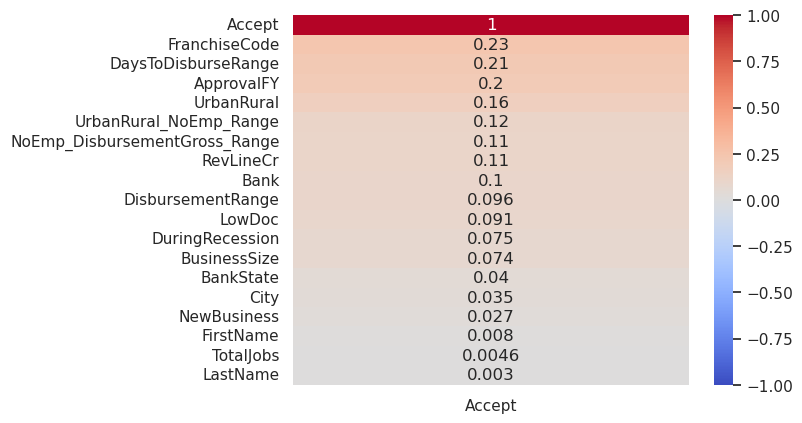

In [188]:
# Select the columns of interest
cols = df.columns.tolist()
cols.remove('Accept')

# Compute the correlation matrix with Accept
corr = df[cols + ["Accept"]].corr()

# Display the correlation coefficients for Accept
print(corr["Accept"].abs().sort_values(ascending=False))

# Create a heatmap
sns.heatmap(corr[["Accept"]].abs().sort_values(by=["Accept"], ascending=False),
            cmap="coolwarm", annot=True, vmin=-1, vmax=1, annot_kws={"size": 12})

Dentro de los campos con mayor correlación, vamos a comprobar si todos ellos aportan información relevante:

# Training

In [189]:
# Features of the model (Over 0.1 of correlation to Accept)
features = corr[abs(corr["Accept"]) > 0.15].index.tolist()
features.remove("Accept")
print(features)

# Transform dataframe in numpy arrays
X = df[features].values
y = df['Accept'].values

# Test set will be the 25% taken randomly
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=33)

['ApprovalFY', 'FranchiseCode', 'UrbanRural', 'DaysToDisburseRange']


# Null accuracy

In [190]:
# Count number of samples per class
s_y_test = Series(y_test)

# Calculate null accuracy (binary classification coded as 0/1)
max(y_test.mean(), 1 - y_test.mean())

# Calculate null accuracy (multiclass classification)
s_y_test.value_counts().head(1) / len(y_test)

1    0.799742
dtype: float64

Fiarse únicamente de la exactitud no es buena práctica si el conjunto de datos no está balanceado, ya que no tiene en cuenta la distribución en clases. Se puede predecir la clase mayoritaria más comunmente por error, y obtener alta exactitud, pero que funcione erroneamente para la minoritaria. Para eso calculamos la null_accuraccy. A la vista de los resultados, es de 0.7997 (79.97%), es decir, en el conjunto de datos hay un 80% de datos de clase 1, por lo que si predijesemos siempre esta clase, acertaríamos un 80% de las veces.

Para que el modelo sea válido, la accuracy tendría que se mayor que la null_accuracy; como en este caso es muy elevada, es muy dificil que se cumpla esta condición y se va a realizar un balanceo del conjunto de datos a continuación.

# Upsampling

In [191]:
# Instantiate SMOTE
smote = SMOTE(random_state=33)

# Apply SMOTE to X_train and y_train
X_balanced, y_balanced = smote.fit_resample(X_train, y_train)

# Display new class counts
print(pd.Series(y_balanced).value_counts())

0    24086
1    24086
dtype: int64


# Downsampling

In [192]:
# Combine features and target variable into a single DataFrame
df_aux = pd.DataFrame(data=X_train, columns=features)
df_aux['Accept'] = y_train

# Separate majority and minority classes
df_majority = df_aux[df_aux.Accept==1]
df_minority = df_aux[df_aux.Accept==0]

# Downsample majority class
df_majority_downsampled = resample(df_majority,replace=False,n_samples=min(df_aux['Accept'].value_counts()),random_state=123)

# Combine minority class with downsampled majority class
df_downsampled = pd.concat([df_majority_downsampled, df_minority])

# Display new class counts
df_downsampled.Accept.value_counts()

# Transform dataframe in numpy arrays
X_balanced = df_downsampled[features].values
y_balanced = df_downsampled['Accept'].values

Ahora podemos comprobar si ha aumentado la correlación entre las columnas escogidas y Accept después del balanceo.

Accept                 1.000000
FranchiseCode          0.283229
DaysToDisburseRange    0.260790
ApprovalFY             0.254777
UrbanRural             0.216224
Name: Accept, dtype: float64


<AxesSubplot:>

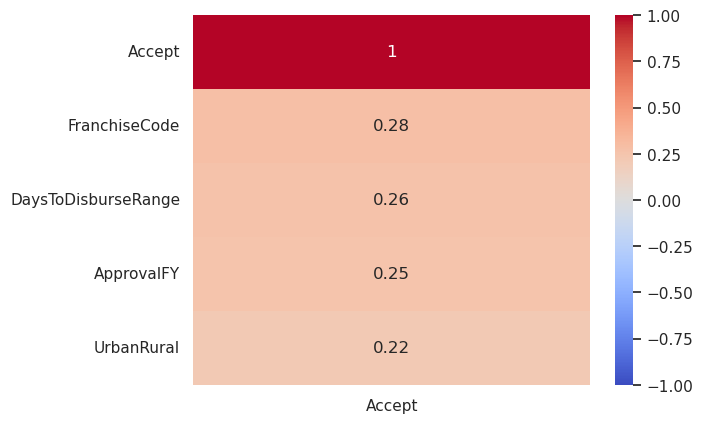

In [193]:
# Select the columns of interest
cols = df_downsampled.columns.tolist()
cols.remove('Accept')

# Compute the correlation matrix with Accept
corr = df_downsampled[cols + ["Accept"]].corr()

# Display the correlation coefficients for Accept
print(corr["Accept"].abs().sort_values(ascending=False))

# Create a heatmap
sns.heatmap(corr[["Accept"]].abs().sort_values(by=["Accept"], ascending=False),
            cmap="coolwarm", annot=True, vmin=-1, vmax=1, annot_kws={"size": 12})

Se puede apreciar como, en este caso, los resultados obtenidos son iguales tanto para el conjunto mayoritario como para el minoritario.

In [ ]:
df_downsampled['Accept'].value_counts()

Una vez hemos llegado a este punto, ya tenemos todos los datos preprocesados y listos para ser entrenados utilizando el algoritmo asignado y los dos algoritmos de nuestra elección, basandonos en las pautas del enunciado.

* Como parte de la competición, es obligatorio para cada equipo emplear un algoritmo geométrico y un árbol de decisión. Por supuesto, el equipo debe usar además el "algoritmo secreto".

Los algoritmos escogidos como geométrico y árbol de decisión son, respectivamente, Logistic Regression y Random Forest. Además, el algoritmo asignado a nuestro equipo es el GaussianNB.

# Geometric Models

## Logistic Regression

En primer lugar, se ha escogido el algoritmo de Logistic Regression, debido a los buenos resultados obtenidos con este en las prácticas realizadas en clase; a continuación se ven los resultados obtenidos para el entrenamiento del modelo con este algoritmo.

In [ ]:
# Filter warning messages
warnings.filterwarnings('ignore')

# Define the parameter grid to search
param_grid_LR = {'C': np.logspace(-3,3,7),
              'penalty': ['l1', 'l2', 'elasticnet'],
              'solver': ['liblinear', 'newton-cg', 'lbfgs', 'sag'],
              'l1_ratio': [0.5]}

# Create Logistic Regression model
model_LR = LogisticRegression()

# Perform grid search
f1 = make_scorer(f1_score)
grid_search_LR = GridSearchCV(model_LR, param_grid=param_grid_LR, cv=5, scoring=f1)
grid_search_LR.fit(X_balanced, y_balanced)

# Print the best hyperparameters and score
print("Best parameters: ", grid_search_LR.best_params_)
print("Best score: ", grid_search_LR.best_score_)

In [ ]:
# Create logistic regression model with best hyperparameters
model_LR = LogisticRegression(penalty=grid_search_LR.best_estimator_.penalty, 
                           l1_ratio=grid_search_LR.best_estimator_.l1_ratio, 
                           C=grid_search_LR.best_estimator_.C, 
                           solver=grid_search_LR.best_estimator_.solver)

# Predict
model_LR.fit(X_balanced, y_balanced)
predicted_LR = model_LR.predict(X_test)
expected_LR = y_test

# Metrics
print_evaluation_metrics(model_LR, predicted_LR, expected_LR)

Resultados best params/score: Entre un 65% y un 67% para todas las pruebas

Resultados accuracy y f1-score: Entre 60-70% y 64-71% para todas las pruebas, respectivamente.

Resultados Kaggle: 56.10% - 61.81% para las dos entregas realizadas. 

Al ser tan distantes los resultados entre sí, conllevando una gran incertidumbre, se ha optado por entregar el entrenamiento con otros modelos, que se verán a continuación.

## SVM

-Realizamos el modelado utilizando el algoritmo SVM. Para el kernel hemos utilizado el 'rbf', ya que era el escogido como mejor opción tras la realización de multiples pruebas, logrando así disminuir los tiempos de ejecución.

In [ ]:
param_grid_SVM = {'C':[10,100],
                  'gamma':[1,0.1,0.01,0.001,0.0001],
                  'kernel':['rbf','linear']}

# Create SVM model
model_SVM = SVC()

# Perform grid search
grid_search_SVM = GridSearchCV(model_SVM, param_grid=param_grid_SVM, cv=5, scoring=f1)
grid_search_SVM.fit(X_balanced, y_balanced)

# Print the best hyperparameters and score
print("Best parameters: ", grid_search_SVM.best_params_)
print("Best score: ", grid_search_SVM.best_score_)

In [ ]:
# Create SVM model
model_SVM = SVC(C=10,
                gamma=0.1,
                kernel='rbf',
                probability= True)

# Predict with the model
model_SVM.fit(X_balanced, y_balanced)
predicted_SVM = model_SVM.predict(X_test)
expected_SVM = y_test

# Metrics
print_evaluation_metrics(model_SVM, predicted_SVM, expected_SVM)

Resultados best params/score: En torno a un 70% para todas las pruebas.

Resultados accuracy y f1-score: En torno al 70% y 73-74% para todas las pruebas, respectivamente.

Resultados Kaggle: Entre un 43.26% y un 65%. 

Al ser tan distantes los resultados entre sí, conllevando una gran incertidumbre, se ha optado por entregar el entrenamiento con otros modelos, que se verán a continuación.

## KNN (k-Nearest Neighbours)

A continuación, se va a realizar el modelado con el algoritmo kNN. Se ha probado a utilizar diferentes métricas para los parámetros, probando la opción de minkovski pero eliminándola al no ser óptima. 

In [ ]:
# Define the parameter grid to search
value_counts = df_downsampled['Accept'].value_counts()
odd_array = build_array(value_counts)

param_grid_KNN = {'n_neighbors': odd_array,
                  'metric': ['euclidean','manhattan', 'chebyshev'],
                  'algorithm': ['brute'],
                  'leaf_size': [1,30]
}

# Create KNN model
model_KNN = KNeighborsClassifier(weights='distance')

# Perform grid search
grid_search_KNN = GridSearchCV(model_KNN, param_grid=param_grid_KNN, cv=5, verbose=1, scoring=f1)
grid_search_KNN.fit(X_balanced, y_balanced)

# Print the best hyperparameters and score
print("Best parameters: ", grid_search_KNN.best_params_)
print("Best score: ", grid_search_KNN.best_score_)

In [ ]:
# Create KNN model
model_KNN = KNeighborsClassifier(n_neighbors=grid_search_KNN.best_estimator_.n_neighbors,
                                metric=grid_search_KNN.best_estimator_.metric,
                                algorithm=grid_search_KNN.best_estimator_.algorithm,
                                leaf_size=grid_search_KNN.best_estimator_.leaf_size)

# Predict with the model
model_KNN.fit(X_balanced, y_balanced)
predicted_KNN = model_KNN.predict(X_test)
expected_KNN = y_test

# Metrics
print_evaluation_metrics(model_KNN, predicted_KNN, expected_KNN)

Resultados best params/score: Entre un 60% y un 72% para todas las pruebas.

Resultados accuracy y f1-score: Entre 70-74% y 73-76% para todas las pruebas, respectivamente.

Resultados Kaggle: 65.05% - 58.78% para las dos entregas realizadas. 

Al ser tan distantes los resultados entre sí, conllevando una gran incertidumbre, se ha optado por entregar el entrenamiento con otros modelos, que se verán a continuación.

## Stacking

In [ ]:
model_SGD = SGDClassifier()

Cs = [0.0001,0.001,0.01,0.1,1,10]

param_grid_SGD = [{'alpha': Cs}]

grid_search_SGD = GridSearchCV(model_SGD, param_grid=param_grid_SGD, cv=5, scoring=f1)

grid_search_SGD.fit(X_balanced, y_balanced)

print("Best parameters: ", grid_search_SGD.best_params_)

model_SGD = SGDClassifier(alpha=grid_search_SGD.best_estimator_.alpha)

In [ ]:
models = [('lr', model_LR),('knn', model_KNN),('svm', model_SVM)]

sclf = StackingClassifier(estimators=models, final_estimator=SGDClassifier(alpha=0.001))

params = {'stack_method': ['auto', 'predict_proba', 'decision_function', 'predict']}

grid = GridSearchCV(estimator=sclf, param_grid=params, cv=5, scoring=f1, verbose=2)
grid.fit(X_balanced, y_balanced)

# Print the best hyperparameters and score
print("Best parameters: ", grid.best_params_)
print("Best score: ", grid.best_score_)

In [ ]:
# Create Stacking Model
model_SCLF = StackingClassifier(estimators=models,
                                final_estimator=SGDClassifier(alpha=0.001),
                                stack_method=grid.best_estimator_.stack_method)

# Predict with the model
model_SCLF.fit(X_balanced, y_balanced)
predicted_SCLF = model_SCLF.predict(X_test)
expected_SCLF = y_test

# Metrics
print_evaluation_metrics2(model_SCLF, predicted_SCLF, expected_SCLF)

Se ha realizado un stacking con cada uno de los 3 modelos entrenados previamente para tratar de mejorar los resultados individuales obtenidos en el entrenamiento, obteniendo los siguientes resultados:

Resultados best params/score: Entre un 72% y un 73% para las pruebas realizadas.

Resultados accuracy y f1-score: Entre 73-74% y 75-76% para todas las pruebas, respectivamente.

Resultados Kaggle: 61.49% - 43.09% para las dos entregas realizadas. 

Debido a la exactitud observada en los resultados anteriores, como connsecuencia de juntar los 3 modelos, es prácticamente igual, se ha decidido descartar este modelo para realizar la entrega definitiva en Kaggle, utilizando para esto los que se verán a continuación.

# Secret Model: GaussianNB

**GaussianNB** es un algoritmo para clasificación supervisada, perteneciente al grupo de Naive Bayes. Clasifica según una probabilidad de pertenecer a una clase terminada.

Utilizando TPOT se han calculado los mejores hiperparámetros para construir el modelo de GaussianNB. Se utiliza un flujo de trabajo exported_pipeline que usa los siguientes elementos:

- MinMaxScaler(): escalar los datos de entrada a un rango determinado (0,1)
- StackingEstimator: es un componente que se utiliza para apilar varios estimadores juntos. En este caso, los dos estimadores apilados son el SGDClassifier y el GradientBoostingClassifier. Ambos son algoritmos de clasificación que se utilizan para predecir la clase de un conjunto de datos.
- SelectPercentile: seleccionar las características más importantes de los datos de entrada. En este caso se usa f_classif para seleccionar el 25% de las más importantes.

In [ ]:
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)

model_GNB = make_pipeline(
    MinMaxScaler(),
    StackingEstimator(estimator=SGDClassifier(alpha=0.0, 
                                              eta0=0.01, 
                                              fit_intercept=False, 
                                              l1_ratio=1.0, 
                                              learning_rate="invscaling", 
                                              loss="hinge", 
                                              penalty="elasticnet", 
                                              power_t=1.0
                                             )
                     ),
    StackingEstimator(estimator=GradientBoostingClassifier(learning_rate=0.1, 
                                                            max_depth=3, 
                                                            max_features=0.8500000000000001, 
                                                            min_samples_leaf=16, 
                                                            min_samples_split=17, 
                                                            n_estimators=100, 
                                                            subsample=0.7500000000000001
                                                            )
                     ),
    SelectPercentile(score_func=f_classif, percentile=25),
    GaussianNB()
)
# Fix random state for all the steps in exported pipeline
set_param_recursive(model_GNB.steps, 'random_state', 33)

model_GNB.fit(X_balanced, y_balanced)

predicted_GNB = model_GNB.predict(X_test)
expected_GNB = y_test

# Metrics
print_evaluation_metrics(model_GNB, predicted_GNB, expected_GNB)

1 intento: Accuracy: 74%. f1: 76%
5 intento: Accuracy: 73.13%. f1: 75%
6 intento: Accuracy: 70.74%. f1: 73% (Solo con 4 features)
7 intento: Accuracy: 69.39%. f1: 72% (Solo con 3 features)
8 intento: Accuracy: 69.71%. f1: 72% (Solo con 2 features)
9 intento: Accuracy: 68.35%. f1: 71% (Con 4 features y estandarizando datos)

Resultados Kaggle: 64.18% - 65.01% - 65.35% - 66.07% - 64.18% - 66.83% (Sube solo con 4 features) - 66.89% (Sube con 3 features) - 65.66% (Con 2 features) - 65.46% (Estandarizando)

Se queda en principio en 4 features y no se estandariza

# Árbol de Decisión: Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier

#Tune parameters
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 10, stop = 80, num = 10)]

# Number of features to consider at every split
max_features = ['auto', 'sqrt']

# Maximum number of levels in tree
max_depth = [2,4]

# Minimum number of samples required to split a node
min_samples_split = [2, 5]

# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2]

# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the param grid
param_grid = {'n_estimators': n_estimators,
              'max_features': max_features,
              'max_depth': max_depth,
              'min_samples_split': min_samples_split,
              'min_samples_leaf': min_samples_leaf,
              'bootstrap': bootstrap}

f1 = make_scorer(f1_score)
gs = GridSearchCV(RandomForestClassifier(), param_grid=param_grid, cv=10, scoring=f1)
gs.fit(X_balanced, y_balanced)
scores = gs.score(X_test, y_test)
print(scores)

In [ ]:
model_RF = RandomForestClassifier(n_estimators=gs.best_estimator_.n_estimators,
                               max_depth=gs.best_estimator_.max_depth,
                               min_samples_split=gs.best_estimator_.min_samples_split,
                               bootstrap=gs.best_estimator_.bootstrap,
                               max_features=gs.best_estimator_.max_features,
                               min_samples_leaf=gs.best_estimator_.min_samples_leaf,
                               random_state=0)

# Predict with the model
model_RF.fit(X_balanced, y_balanced)
predicted_RF = model_RF.predict(X_test)
expected_RF = y_test

# Metrics
print_evaluation_metrics(model_RF, predicted_RF, expected_RF)

Resultados celda arriba: 
* 1 intento: 73.39%
* 2 intento: 72.19%
* 3 intento: 72.81%
* 4 intento: 78.73%
* 5 intento: 79.23% (Solo con 4 features)
* 6 intento: 78.77% (Con 3 features)

4 intento: Accuracy: 70.26%. f1: 73%
5 intento: Accuracy: 70.34%. f1: 73%
6 intento: Accuracy: 69.70%. f1: 72%

Resultados Kaggle: 64.83% - 63.83% - 64.25% - 65.29% - 65.82% (Solo con 4 features) - 65.88% (Con 3 features)

# Árbol de decisión de XGBClassifier

**XGBClassifier** es un algoritmo para clasificación supervisada, basado en árboles de decisión, que se utiliza para predecir una clase, en este caso Accept 0 o 1, para un conjunto de datos en función de varias características de entrada.

Se basa en la implementación de Extreme Gradient Boosting (XGBoost), que utiliza árboles de decisión y boosting para mejorar la precisión de las predicciones.

Se construyen múltiples modelos débiles en secuencia (árboles de decisión), centrados en los errores del modelo anterior. Se agregan en serie para mejorar la precisión y minimizar el error de clasificación.

Los parámetros óptimos de este modelo se han logrado utilizando TPOT con 5 generaciones y una población de 50.

In [ ]:
# A parameter grid for XGBoost
params = {
        'min_child_weight': [1, 5, 8, 10],
        'gamma': [0.5, 1, 1.5, 2, 5],
        'subsample': [0.4, 0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [3, 4, 5]
        }

xgb = XGBClassifier(learning_rate=0.02, n_estimators=600, objective='binary:logistic', nthread=1)

folds = 10
param_comb = 5

skf = StratifiedKFold(n_splits=folds, shuffle = True, random_state = 33)

random_search = RandomizedSearchCV(xgb, param_distributions=params, n_iter=param_comb, scoring='roc_auc', 
                                   n_jobs=4, cv=skf.split(X_balanced, y_balanced), verbose=0, random_state=33 )

# Here we go
random_search.fit(X_balanced, y_balanced)

In [ ]:
# Create XGBClassifier Model
model_XGB = XGBClassifier(learning_rate=random_search.best_estimator_.learning_rate,
                          max_depth=random_search.best_estimator_.max_depth,
                          min_child_weight=random_search.best_estimator_.min_child_weight,
                          n_estimators=random_search.best_estimator_.n_estimators,
                          n_jobs=random_search.best_estimator_.n_jobs,
                          subsample=random_search.best_estimator_.subsample,
                          verbosity=0
                         )

# Predict with the model
model_XGB.fit(X_balanced, y_balanced)
predicted_XGB = model_XGB.predict(X_test)
expected_XGB = y_test

# Metrics
print_evaluation_metrics(model_XGB, predicted_XGB, expected_XGB)

1 intento: Accuracy: 71.84%. f1: 75%
16 intento: Accuracy: 73.71%. f1: 76%
17 intento: Accuracy: 70.77%. f1: 73% (Solo con 4 features)
18 intento: Accuracy: 69.47%. f1: 72% (Solo con 3 features)

Resultados Kaggle: 59.22% - 62.37% - 56.87% - 56.13% - 62.54% - 66.33% - 65.68% - 65.82% - 61.44% - 37.06% - 65.23% - 67.06% - 66.95% - 51.33% - 58.18% - 57.84% - 66.52% (Sube solo con 4 features) - 66.74% (Solo con 3 features)

# Red Neuronal

In [219]:
# Select the columns of interest
cols = df.columns.tolist()
cols.remove('Accept')

# Compute the correlation matrix with Accept
corr = df[cols + ["Accept"]].corr()

# Features of the model (Over 0.1 of correlation to Accept)
features = corr[abs(corr["Accept"]) >= 0.09].index.tolist()
features.remove("Accept")
features.remove("Bank")
features.remove("NoEmp_DisbursementGross_Range")
features.remove("UrbanRural_NoEmp_Range")
print(features)

# Transform dataframe in numpy arrays
X = df[features].values
y = df['Accept'].values

# Test set will be the 25% taken randomly
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=33)

['ApprovalFY', 'FranchiseCode', 'UrbanRural', 'RevLineCr', 'LowDoc', 'DaysToDisburseRange', 'DisbursementRange']


## Downsampling

In [220]:
# Combine features and target variable into a single DataFrame
df_aux = pd.DataFrame(data=X_train, columns=features)
df_aux['Accept'] = y_train

# Separate majority and minority classes
df_majority = df_aux[df_aux.Accept==1]
df_minority = df_aux[df_aux.Accept==0]

# Downsample majority class
df_majority_downsampled = resample(df_majority,replace=False,n_samples=min(df_aux['Accept'].value_counts()),random_state=123)

# Combine minority class with downsampled majority class
df_downsampled = pd.concat([df_majority_downsampled, df_minority])

# Display new class counts
df_downsampled.Accept.value_counts()

# Transform dataframe in numpy arrays
X_balanced = df_downsampled[features].values
y_balanced = df_downsampled['Accept'].values

# Display new class counts
print(pd.Series(y_balanced).value_counts())

1    6202
0    6202
dtype: int64


In [221]:
# Generate TrainX and TrainY
X_bal_train, X_bal_val, y_bal_train, y_bal_val = train_test_split(X_balanced, y_balanced, test_size= 0.15)

In [222]:
print(X_bal_train.shape)
print(X_bal_val.shape)
print(X_test.shape)

(10543, 7)
(1861, 7)
(10097, 7)


In [223]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_bal_train = scaler.fit_transform(X_bal_train)

X_bal_val = scaler.fit_transform(X_bal_val)
X_test = scaler.fit_transform(X_test)

In [208]:
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [224]:
import keras
from keras.wrappers.scikit_learn import KerasClassifier
from keras import regularizers
from keras.utils import np_utils
from sklearn_pandas import DataFrameMapper
from tensorflow.keras import Sequential, Input
from tensorflow.keras.layers import Dense, Dropout, LeakyReLU
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import optimizers
from tensorflow.keras import initializers

input_shape = X_bal_train.shape[1]

n_batch_size = 64

n_steps_per_epoch = int(X_bal_train.shape[0] / n_batch_size)
n_validation_steps = int(X_bal_val.shape[0] / n_batch_size)

n_epochs = 100

print('Input Shape: ' + str(input_shape))
print('Batch Size: ' + str(n_batch_size))
print('Steps per Epoch: ' + str(n_steps_per_epoch))
print('Validation Steps: ' + str(n_validation_steps))
print('Number of Epochs: ' + str(n_epochs))

model_NN = Sequential()

model_NN.add(Dense(2048, activation='relu', input_shape=(input_shape,)))
model_NN.add(Dropout(0.5))
model_NN.add(Dense(1024, activation='relu'))
model_NN.add(Dropout(0.5))
model_NN.add(Dense(512, activation='relu'))
model_NN.add(Dropout(0.5))
model_NN.add(Dense(256, activation='relu'))

model_NN.add(Dense(1, activation='sigmoid'))
model_NN.summary()

# sgd=optimizers.SGD(learning_rate=0.01)

model_NN.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=f1_m)

# early stopping callback
# This callback will stop the training when there is no improvement in  
# the validation loss for 10 consecutive epochs.  
es = EarlyStopping(monitor='val_f1_m', 
                                   mode='max',
                                   patience=10,
                                   restore_best_weights=True)

history = model_NN.fit(
    X_bal_train,
    y_bal_train,
    steps_per_epoch=n_steps_per_epoch,
                    epochs=n_epochs,
                    batch_size=n_batch_size,
                    validation_data=(X_bal_val, y_bal_val),
                    validation_steps=n_validation_steps,
                     callbacks=[es],
                    verbose=2
)

Input Shape: 7
Batch Size: 64
Steps per Epoch: 164
Validation Steps: 29
Number of Epochs: 100
Model: "sequential_32"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_180 (Dense)           (None, 2048)              16384     
                                                                 
 dropout_116 (Dropout)       (None, 2048)              0         
                                                                 
 dense_181 (Dense)           (None, 1024)              2098176   
                                                                 
 dropout_117 (Dropout)       (None, 1024)              0         
                                                                 
 dense_182 (Dense)           (None, 512)               524800    
                                                                 
 dropout_118 (Dropout)       (None, 512)               0         
                         

316/316 - 2s - loss: 0.5949 - f1_m: 0.7829 - 2s/epoch - 8ms/step
Test loss: 0.5949358344078064
Test f1: 0.7829360961914062
316/316 [==============================] - 3s 8ms/step
Accuracy Score:
69.72368%


Confusion Matrix:
[[1419  603]
 [2454 5621]]


Classification Report:
              precision    recall  f1-score   support

           0       0.37      0.70      0.48      2022
           1       0.90      0.70      0.79      8075

    accuracy                           0.70     10097
   macro avg       0.63      0.70      0.63     10097
weighted avg       0.80      0.70      0.73     10097



316/316 [==============================] - 3s 8ms/step
AUC:  0.6989397433188487


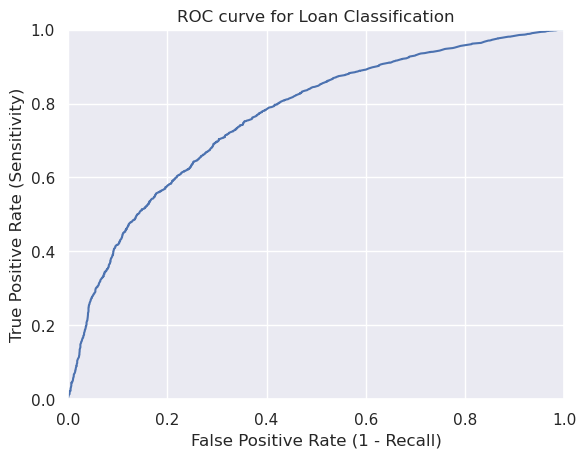

In [225]:
test_eval = model_NN.evaluate(X_test, y_test, verbose=2)

print('Test loss:', test_eval[0])
print('Test f1:', test_eval[1])

predicted_NN = model_NN.predict(X_test)
predicted_NN = np.round(predicted_NN,0).astype(np.int32)
predicted_NN = np.squeeze(predicted_NN)

# Metrics
print_evaluation_metrics_nn(model_NN, predicted_NN, y_test)

# Preparación Submission

In [226]:
# Red Neuronal
x_nolabel = dfnolabel[features]
x_nolabel = scaler.fit_transform(x_nolabel)
y_nolabel = model_NN.predict(x_nolabel)
y_nolabel = np.round(y_nolabel,0).astype(np.int32)
y_nolabel = np.squeeze(y_nolabel)
id = dfnolabel['id']

103/103 [==============================] - 1s 8ms/step


In [ ]:
x_nolabel = dfnolabel[features]
y_nolabel = model_XGB.predict(x_nolabel)
dfnolabel = dfnolabel.reset_index(drop=True)
id = dfnolabel['id']

In [ ]:
dfsave = pd.DataFrame({'id': id, 'Accept': y_nolabel}, columns=["id", "Accept"])

# Guardar el DataFrame modificado en un archivo CSV
dfsave.to_csv('submission-XGB-20.csv', index=False, header=True)